# Motion Adaptation tACS Project
### Analysis of 3-way interaction - tACS x Hemisphere x Adaptation
### Analyses performed on 264 Power set 2 added ROIs (lMT = ROI 265; rMT = ROI 266)

Taku Ito
4/12/16

In [4]:
N = maxNumCompThreads(10);
basedir = '/projects/Collaborations/KrekelbergCollaboration/MotionAdaptation_tACS_FC/';
datadir = [basedir 'data/results/PowerAnalyses/'];
subjNums = {'038', '069', '083', '141', '144', '170', '172', '173', ...
            '177', '178'};

% Load in Power Network Affiliation
power11 = importdata('Power11NewCoorOrder.txt');
%power11 = power11(:,5);
% Load data
subj_data = {};
subjcount = 1;
tacsontimes = {};
tacsofftimes = {};
opptimes = {};
sametimes = {};
for subj=subjNums
    subjfile = [datadir subj{1} '_266Power_timeseries.csv'];

    % Import entire timeseries for subject
    subj_data{subjcount} = csvread(subjfile);
    
    % Import the length of tacs off runs (2 runs total)
    tacsonsetfile = [datadir subj{1} '_266Power_timeseries_tacsOff.csv'];
    tmp = csvread(tacsonsetfile);
    tacsoffset = size(tmp,2); % Obtain length of timeseries only
    % Generate stimulus arrays
    tacsofftimes{subjcount} = zeros(size(subj_data{subjcount},2),1);
    tacsontimes{subjcount} = zeros(size(subj_data{subjcount},2),1);
    tacsofftimes{subjcount}(1:tacsoffset) = 1;
    tacsontimes{subjcount}((tacsoffset+1):end) = 1;
    clear tmp
    
    % Import convolved stim files for same condition (adapted condition)
    stimdir = [basedir 'data/' subj{1} '/sdm/'];
    same_tmp = importdata([stimdir 'SameTimes.1D']);
    opp_tmp = importdata([stimdir 'OppTimes.1D']);
    % Binarize convolved time series to obtain only portions in which HRF activation > 0.5
    sametimes{subjcount} = same_tmp > 0.0;
    opptimes{subjcount} = opp_tmp > 0.0;
    
    subjcount = subjcount + 1;
end


[Warning: maxNumCompThreads will be removed in a future release. Please remove
any instances of this function from your code.] 
[> In maxNumCompThreads at 26
  In pymat_eval at 31
  In matlabserver at 24]


#### Break up time series to obtain relevant fc matrices to perform interaction analysis
For each subject, organized as a 266 (regions) x 8 (conditions) vector, where the columns are organized as follows:
1. lMT | tACS OFF | SAME
2. lMT | tACS OFF | OPP
3. lMT | tACS ON  | SAME
4. lMT | tACS ON  | OPP
5. rMT | tACS OFF | SAME
6. rMT | tACS OFF | OPP
7. rMT | tACS ON  | SAME
8. rMT | tACS ON  | OPP

In [5]:
% Organize matrices
fc_vectors = zeros(8,10,266);

for subj=1:length(subjNums)
    
    % tACS OFF | SAME condition
    tacsoff_same = sametimes{subj}.*tacsofftimes{subj};
    ind = find(tacsoff_same);
    fc = corrcoef(subj_data{subj}(:,ind)');
    fc_vectors(1,subj,:) = fc(265,:); % left MT connectivity
    fc_vectors(5,subj,:) = fc(266,:); % right MT connectivity
    
    % tACS OFF | OPP condition
    tacsoff_opp = opptimes{subj}.*tacsofftimes{subj};
    ind = find(tacsoff_opp);
    fc = corrcoef(subj_data{subj}(:,ind)');
    fc_vectors(2,subj,:) = fc(265,:); % left MT connectivity
    fc_vectors(6, subj,:) = fc(266,:); % right MT connectivity
    
    % tACS ON | SAME
    tacson_same = sametimes{subj}.*tacsontimes{subj};
    ind = find(tacson_same);
    fc = corrcoef(subj_data{subj}(:,ind)');
    fc_vectors(3,subj,:) = fc(265,:); % left MT connectivity
    fc_vectors(7,subj,:) = fc(266,:); % right MT connectivity
    
    % tACS ON | OPP condition
    tacson_opp = opptimes{subj}.*tacsontimes{subj};
    ind = find(tacson_opp);
    fc = corrcoef(subj_data{subj}(:,ind)');
    fc_vectors(4,subj,:) = fc(265,:); % left MT connectivity
    fc_vectors(8,subj,:) = fc(266,:);
end

#### Run 4-way ANOVA, with 3 fixed effects, 1 random effects

In [6]:
% Define group names
adapt = {'same';'opp';'same';'opp';'same';'opp';'same';'opp';};
adapt = repmat(adapt,10,1);
tacs = {'tacs_off';'tacs_off'; 'tacs_on'; 'tacs_on';'tacs_off';'tacs_off'; 'tacs_on'; 'tacs_on';};
tacs = repmat(tacs,10,1);
hemi = {'left';'left';'left';'left';'right';'right';'right';'right'};
hemi = repmat(hemi,10,1);
subjs = reshape(repmat(1:10',8,1),[80,1]);
ps = cell(266,1);
interactionF = zeros(266,1);
interactionP = zeros(266,1);
for roi=1:266
    indata = reshape(fc_vectors(:,:,roi),[80,1]);
    [p,tbl] = anovan(indata,{adapt,tacs,hemi,subjs}, 'model', 'full','random',[4], 'varnames', {'adapt','tacs','hemi','subjs'});
    interactionF(roi) = tbl{12,6};
    interactionP(roi) = tbl{12,7};
end

In [7]:
[fdr, q] = mafdr(interactionP);
% Identify q-values with < 0.1 
q_bin = q < 0.1;
ind = find(q_bin);
disp('ROIs with q < 0.1:')
for i=1:length(ind)
    disp(['ROI ' num2str(ind(i)) ' with q = ' num2str(q(ind(i)))])
end

ROIs with q < 0.1:


In [8]:
tmp = find((interactionP<0.05));
interactionP(tmp)

ans =

    0.0462
    0.0178
    0.0462
    0.0202
    0.0275
    0.0109
    0.0312
    0.0171
    0.0477
    0.0222
    0.0050
    0.0100
    0.0029
    0.0179
    0.0288
    0.0070
    0.0059
    0.0109
    0.0435
    0.0440
    0.0462
    0.0253
    0.0300
    0.0482
    0.0036
    0.0313
    0.0232


#### Results description:
No FC ROIs were significantly lower than 0.05 after FDR correction

# Next step: Look at 2-way interaction of just Hemisphere and tACS

In [12]:
% Define group names
adapt = {'same';'opp';'same';'opp';'same';'opp';'same';'opp';};
adapt = repmat(adapt,10,1);
tacs = {'tacs_off';'tacs_off'; 'tacs_on'; 'tacs_on';'tacs_off';'tacs_off'; 'tacs_on'; 'tacs_on';};
tacs = repmat(tacs,10,1);
hemi = {'left';'left';'left';'left';'right';'right';'right';'right'};
hemi = repmat(hemi,10,1);
subjs = reshape(repmat(1:10',8,1),[80,1]);
ps = cell(266,1);
interactionF = zeros(266,1);
interactionP = zeros(266,1);
for roi=1:266
    indata = reshape(fc_vectors(:,:,roi),[80,1]);
    [p,tbl] = anovan(indata,{adapt,tacs,hemi,subjs}, 'model', 'full','random',[4], 'varnames', {'adapt','tacs','hemi','subjs'});
    interactionF(roi) = tbl{9,6};
    interactionP(roi) = tbl{9,7};
end

In [37]:
[fdr, q] = mafdr(interactionP);
% Identify q-values with < 0.1 
q_bin = q < 0.1;
ind = find(q_bin);
disp('ROIs with q < 0.1:')
for i=1:length(ind)
    disp(['ROI ' num2str(ind(i)) ' with q = ' num2str(q(ind(i)))])
end

ROIs with q < 0.1:
ROI 112 with q = 0.085565
ROI 115 with q = 0.04492


# Consider the possibility that there are not enough time points for a robust FC estimate given that we're splitting up across both conditions and tACS on v. off

### Re-run with a 3-way ANOVA, using 2 fixed effects (hemisphere and tACS) and 1 random effects (subjects)

#### Organization of ANOVA input matrix
1. lMT | tACS OFF
2. lMT | tACS ON 
3. rMT | tACS OFF
4. rMT | tACS ON 

In [2]:
% Organize matrices
fc_vectors2x2 = zeros(4,10,266);

for subj=1:length(subjNums)
    
    % tACS OFF
    ind = find(tacsofftimes{subj});
    fc = corrcoef(subj_data{subj}(:,ind)');
    fc_vectors2x2(1,subj,:) = fc(265,:); % left MT connectivity
    fc_vectors2x2(3,subj,:) = fc(266,:); % right MT connectivity
    
    % tACS ON
    ind = find(tacsontimes{subj});
    fc = corrcoef(subj_data{subj}(:,ind)');
    fc_vectors2x2(2,subj,:) = fc(265,:); % left MT connectivity
    fc_vectors2x2(4, subj,:) = fc(266,:); % right MT connectivity
    
end

Run ANOVA

In [3]:
% Define group names
tacs = {'tacs_off';'tacs_on'; 'tacs_off';'tacs_on';};
tacs = repmat(tacs,10,1);
hemi = {'left';'left';'right';'right'};
hemi = repmat(hemi,10,1);
subjs = reshape(repmat(1:10',4,1),[40,1]);
ps = cell(266,1);
interactionF2x2 = zeros(266,1);
interactionP2x2 = zeros(266,1);
for roi=1:266
    indata = reshape(fc_vectors2x2(:,:,roi),[40,1]);
    [p,tbl] = anovan(indata,{tacs,hemi,subjs}, 'model', 'full','random',[3], 'varnames', {'tacs','hemi','subjs'});
    interactionF2x2(roi) = tbl{5,6};
    interactionP2x2(roi) = tbl{5,7};
end

FDR Correction

In [5]:
[fdr2x2, q2x2] = mafdr(interactionP2x2);
% Identify q-values with < 0.1 
q_bin2x2 = q2x2 < 0.1;
ind = find(q_bin2x2);
disp('ROIs with q < 0.1:')
for i=1:length(ind)
    disp(['ROI ' num2str(ind(i)) ' with q = ' num2str(q2x2(ind(i)))])
end

ROIs with q < 0.1:
ROI 115 with q = 0.069713


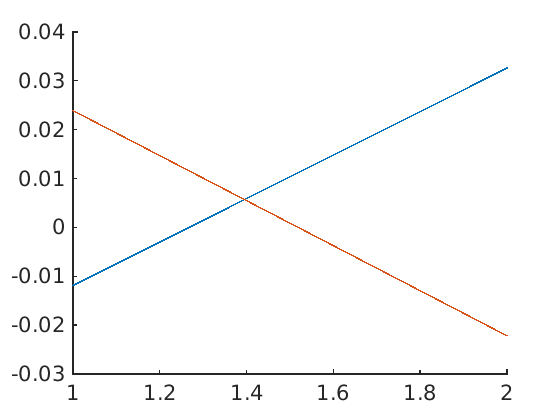

In [10]:
figure
lmt = [mean(fc_vectors2x2(1,:,115)), mean(fc_vectors2x2(2,:,115))];
rmt = [mean(fc_vectors2x2(3,:,115)), mean(fc_vectors2x2(4,:,115))];
hold on
plot(lmt)
plot(rmt)

# Evaluate whether or not GBC is significantly different for hMT+ and see if there's an interaction

In [ ]:
fc > 0

In [7]:
% Organize matrices
gbc_vectors = zeros(8,10);
%pos_fc = fc > 0;

for subj=1:length(subjNums)
    
    % tACS OFF | SAME condition
    tacsoff_same = sametimes{subj}.*tacsofftimes{subj};
    ind = find(tacsoff_same);
    fc = corrcoef(subj_data{subj}(:,ind)');
    gbc_vectors(1,subj) = mean(fc(265,:)); % left MT connectivity
    gbc_vectors(5,subj) = mean(fc(266,:)); % right MT connectivity
    
    % tACS OFF | OPP condition
    tacsoff_opp = opptimes{subj}.*tacsofftimes{subj};
    ind = find(tacsoff_opp);
    fc = corrcoef(subj_data{subj}(:,ind)');
    gbc_vectors(2,subj) = mean(fc(265,:)); % left MT connectivity
    gbc_vectors(6, subj) = mean(fc(266,:)); % right MT connectivity
    
    % tACS ON | SAME
    tacson_same = sametimes{subj}.*tacsontimes{subj};
    ind = find(tacson_same);
    fc = corrcoef(subj_data{subj}(:,ind)');
    gbc_vectors(3,subj) = mean(fc(265,:)); % left MT connectivity
    gbc_vectors(7,subj) = mean(fc(266,:)); % right MT connectivity
    
    % tACS ON | OPP condition
    tacson_opp = opptimes{subj}.*tacsontimes{subj};
    ind = find(tacson_opp);
    fc = corrcoef(subj_data{subj}(:,ind)');
    gbc_vectors(4,subj) = mean(fc(265,:)); % left MT connectivity
    gbc_vectors(8,subj) = mean(fc(266,:));
end

In [39]:
% Define group names
adapt = {'same';'opp';'same';'opp';'same';'opp';'same';'opp';};
adapt = repmat(adapt,10,1);
tacs = {'tacs_off';'tacs_off'; 'tacs_on'; 'tacs_on';'tacs_off';'tacs_off'; 'tacs_on'; 'tacs_on';};
tacs = repmat(tacs,10,1);
hemi = {'left';'left';'left';'left';'right';'right';'right';'right'};
hemi = repmat(hemi,10,1);
subjs = reshape(repmat(1:10',8,1),[80,1]);

indata = reshape(gbc_vectors,[80,1]);
[p,tbl] = anovan(indata,{adapt,tacs,hemi,subjs}, 'model', 'full','random',[4], 'varnames', {'adapt','tacs','hemi','subjs'});
gbc_interactionF = tbl{12,6};
gbc_interactionP = tbl{12,7};


In [41]:
disp('Interaction of GBC of MTs')
disp(['p = ' num2str(gbc_interactionP)])

Interaction of GBC of MTs
p = 0.14096
